<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/003-DL-Feature_extraction-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction Notebook - Camera & LiDAR

## Overview
This notebook extracts deep features from preprocessed camera images and LiDAR scans for sensor fusion and loop closure detection. It implements two parallel feature extraction branches:

1. **Visual Branch**: MobileNet V2 → 1280D features (pretrained on ImageNet)
2. **Geometric Branch**: 1D CNN → 256D features (trained using contrastive learning)

Features are saved in HDF5 format with nanosecond-precision timestamps for efficient storage and retrieval.

## Prerequisites
**Required Input Data:**
- Preprocessed camera images in `processed_images/` directory
  - Images in JPEG format (e.g., `img_00000.jpg`, `img_00001.jpg`, ...)
  - `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec, frame_id
- Preprocessed LiDAR scans in `processed_lidar/` directory
  - Scans in CSV format (e.g., `scan_00000.csv`, `scan_00001.csv`, ...)
  - Each CSV contains 360 normalized distance values [0, 1]
  - `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec
- Timestamps recorded for both datasets

**Minimum Data Requirements:**
- Camera images: 10+ images (50+ recommended for training)
- LiDAR scans: 50+ scans (100+ recommended for good training)
- Temporal span: 30+ seconds (for creating diverse training pairs)

## Pipeline Architecture
```
Camera Images (224×224) → MobileNet V2 → 1280D → L2 Norm → Visual Features
LiDAR Scans (360,) → 1D CNN → 256D → L2 Norm → Geometric Features
                             ↓
                  Contrastive Training
                   (Self-supervised)
                             ↓
                  HDF5 Feature Database
           (with nanosecond-precision timestamps)
```

## Expected Runtime
- **With GPU (T4)**: 5-8 minutes total (training: ~3 min)
- **With GPU (V100/A100)**: 3-5 minutes total (training: ~2 min)
- **CPU only**: 25-35 minutes total (training: ~15 min)

## Section 0: Environment Setup & GPU Detection

### Purpose
- Install required packages
- Detect and configure GPU (if available)
- Set up Google Drive mounting (for Colab)
- Verify environment is ready

### Expected Output
- Confirmation of GPU availability (or CPU fallback)
- List of installed packages
- Drive mount status (if using Colab)

In [1]:
# Install required packages
# Note: Colab has torch pre-installed, avoid version conflicts
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} already installed")
except ImportError:
    !pip install --quiet torch torchvision
    print("✓ PyTorch installed")

!pip install --quiet h5py pandas numpy matplotlib tqdm pillow

print("✓ All packages ready!")

✓ PyTorch 2.8.0+cu126 already installed
✓ All packages ready!


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import json
import os
from datetime import datetime
import random
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [3]:
# GPU Detection and Configuration
print("=" * 70)
print("GPU DETECTION & CONFIGURATION")
print("=" * 70)

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # GB

    print(f"✓ GPU AVAILABLE")
    print(f"  Device: {gpu_name}")
    print(f"  Memory: {gpu_memory:.1f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"\n⚡ Expected total runtime: ~5-8 minutes")
    print(f"  • Camera extraction: ~30-60 seconds")
    print(f"  • LiDAR training: ~3-5 minutes")
    print(f"  • LiDAR extraction: ~10-20 seconds")
else:
    device = torch.device('cpu')
    print(f"⚠ NO GPU DETECTED - Using CPU")
    print(f"  Training will be significantly slower on CPU")
    print(f"\n⏱ Expected total runtime: ~25-35 minutes")
    print(f"  • Camera extraction: ~3-5 minutes")
    print(f"  • LiDAR training: ~15-20 minutes")
    print(f"  • LiDAR extraction: ~2-3 minutes")
    print(f"\n💡 TIP: In Colab, enable GPU via:")
    print(f"     Runtime → Change runtime type → Hardware accelerator → GPU")

print(f"\nActive device: {device}")
print("=" * 70)

GPU DETECTION & CONFIGURATION
✓ GPU AVAILABLE
  Device: NVIDIA A100-SXM4-80GB
  Memory: 79.3 GB
  CUDA Version: 12.6

⚡ Expected total runtime: ~5-8 minutes
  • Camera extraction: ~30-60 seconds
  • LiDAR training: ~3-5 minutes
  • LiDAR extraction: ~10-20 seconds

Active device: cuda


In [4]:
# Mount Google Drive (for Colab users)
# Skip this cell if running locally

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully")
    IN_COLAB = True
except:
    print("ℹ Not running in Colab - skipping Drive mount")
    IN_COLAB = False

Mounted at /content/drive
✓ Google Drive mounted successfully


In [5]:
# Configure Session and Paths
# MODIFY THESE VARIABLES FOR YOUR DATA

# session = '20251016_133216'  # ← Change this to your session ID
session = '20251022_155137'

# Path configuration (modify if needed)
if IN_COLAB:
    # Google Drive path for Colab
    data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot"
else:
    # Local path
    data_path = "./data"  # ← Change this to your local data path

working_folder = os.path.join(data_path, f'session_{session}')

print(f"Session ID: {session}")
print(f"Working folder: {working_folder}")

# Change to working directory
if os.path.exists(working_folder):
    os.chdir(working_folder)
    print(f"✓ Changed directory to: {os.getcwd()}")
else:
    print(f"❌ ERROR: Working folder not found!")
    print(f"   Please check the path: {working_folder}")
    raise FileNotFoundError(f"Directory not found: {working_folder}")

# Input directories (relative to working folder)
CAMERA_DIR = 'processed_images'
LIDAR_DIR = 'processed_lidar'

# Output directory (for features and results)
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Output files
FEATURES_FILE = os.path.join(OUTPUT_DIR, 'features.h5')
SUMMARY_FILE = os.path.join(OUTPUT_DIR, 'feature_extraction_summary.json')

print("\n📁 Configuration:")
print(f"  Camera data: {CAMERA_DIR}")
print(f"  LiDAR data: {LIDAR_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Features file: {FEATURES_FILE}")

Session ID: 20251022_155137
Working folder: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
✓ Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137

📁 Configuration:
  Camera data: processed_images
  LiDAR data: processed_lidar
  Output directory: output
  Features file: output/features.h5


In [6]:
# Copy Data to Local Storage (for faster processing)
print("=" * 70)
print("COPYING DATA TO LOCAL STORAGE")
print("=" * 70)

import shutil

# Check available disk space
disk_usage = shutil.disk_usage('/')
available_gb = disk_usage.free / (1024**3)
print(f"Available disk space: {available_gb:.1f} GB\n")

if available_gb < 2:
    print("⚠ WARNING: Low disk space. Skipping local copy.")
    print("  Processing will continue but may be slower.\n")
    USE_LOCAL_STORAGE = False
else:
    USE_LOCAL_STORAGE = True

    # Define local storage paths
    LOCAL_CAMERA_DIR = '/tmp/processed_images'
    LOCAL_LIDAR_DIR = '/tmp/processed_lidar'

    # Helper function to copy with progress bar
    def copy_with_progress(src_dir, dst_dir, desc="Copying"):
        """Copy directory with tqdm progress bar"""
        # Get list of all files
        all_files = []
        for root, dirs, files in os.walk(src_dir):
            for file in files:
                src_path = os.path.join(root, file)
                rel_path = os.path.relpath(src_path, src_dir)
                dst_path = os.path.join(dst_dir, rel_path)
                all_files.append((src_path, dst_path))

        # Create destination directory
        os.makedirs(dst_dir, exist_ok=True)

        # Copy files with progress bar
        total_size = 0
        for src_path, dst_path in tqdm(all_files, desc=desc, unit='file'):
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy2(src_path, dst_path)
            total_size += os.path.getsize(dst_path)

        return total_size

    # Copy camera data
    if os.path.exists(LOCAL_CAMERA_DIR):
        print("ℹ Camera data already in local storage (from previous run)")
        camera_size = sum(os.path.getsize(os.path.join(dirpath, f))
                         for dirpath, _, filenames in os.walk(LOCAL_CAMERA_DIR)
                         for f in filenames)
        print(f"  Size: {camera_size / (1024**2):.1f} MB\n")
    else:
        print("📸 Copying camera data to local storage...")
        camera_size = copy_with_progress(CAMERA_DIR, LOCAL_CAMERA_DIR, "📸 Camera files")
        print(f"  ✓ Copied {camera_size / (1024**2):.1f} MB\n")

    # Copy LiDAR data
    if os.path.exists(LOCAL_LIDAR_DIR):
        print("ℹ LiDAR data already in local storage (from previous run)")
        lidar_size = sum(os.path.getsize(os.path.join(dirpath, f))
                        for dirpath, _, filenames in os.walk(LOCAL_LIDAR_DIR)
                        for f in filenames)
        print(f"  Size: {lidar_size / (1024**2):.1f} MB\n")
    else:
        print("🌐 Copying LiDAR data to local storage...")
        lidar_size = copy_with_progress(LIDAR_DIR, LOCAL_LIDAR_DIR, "🌐 LiDAR files")
        print(f"  ✓ Copied {lidar_size / (1024**2):.1f} MB\n")

    # Update paths to use local storage
    CAMERA_DIR = LOCAL_CAMERA_DIR
    LIDAR_DIR = LOCAL_LIDAR_DIR

    print("✅ Data ready in local storage")
    print("  This will significantly speed up processing!")
    print(f"  Camera dir: {CAMERA_DIR}")
    print(f"  LiDAR dir: {LIDAR_DIR}")

print("=" * 70)

COPYING DATA TO LOCAL STORAGE
Available disk space: 196.4 GB

📸 Copying camera data to local storage...


📸 Camera files: 100%|██████████| 7195/7195 [02:04<00:00, 57.66file/s] 


  ✓ Copied 121.2 MB

🌐 Copying LiDAR data to local storage...


🌐 LiDAR files: 100%|██████████| 2978/2978 [00:54<00:00, 54.43file/s] 

  ✓ Copied 10.2 MB

✅ Data ready in local storage
  This will significantly speed up processing!
  Camera dir: /tmp/processed_images
  LiDAR dir: /tmp/processed_lidar


---

## Section 1: Data Validation

### Purpose
Verify that all required input data exists and is properly formatted before proceeding with feature extraction.

### Expected Inputs
**Camera Data** (`processed_images/`):
- Directory containing JPEG images
- `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec, frame_id
- Images should be 224×224 RGB (preprocessed for MobileNet V2)

**LiDAR Data** (`processed_lidar/`):
- Directory containing CSV scan files
- `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec
- Each scan CSV should have 360 values normalized to [0, 1]

### Validation Checks
1. ✓ Directories exist
2. ✓ Metadata files exist and are readable
3. ✓ Required columns present
4. ✓ Sufficient data for training (minimum thresholds)
5. ✓ Sample files can be loaded
6. ✓ Data format is correct

### Expected Output
- Number of camera images and LiDAR scans found
- Timestamp ranges for both modalities
- Sample image and scan visualization
- Validation checks (all passed)

In [7]:
# Load Camera Data
print("=" * 70)
print("LOADING CAMERA DATA")
print("=" * 70)

# Load metadata with nanosecond precision
camera_metadata_path = os.path.join(CAMERA_DIR, 'metadata.csv')
camera_metadata = pd.read_csv(camera_metadata_path)

# Verify required columns exist
required_cols = ['filename', 'timestamp_sec', 'timestamp_nsec']
missing_cols = set(required_cols) - set(camera_metadata.columns)
if missing_cols:
    raise ValueError(f"Missing columns in camera metadata: {missing_cols}")

print(f"✓ Loaded {len(camera_metadata)} camera images")
print(f"  Columns: {list(camera_metadata.columns)}")

# Display sample
print("\n📋 Sample camera metadata:")
print(camera_metadata.head(3))

# Timestamp range
min_ts = camera_metadata['timestamp_sec'].min() + camera_metadata['timestamp_nsec'].min() * 1e-9
max_ts = camera_metadata['timestamp_sec'].max() + camera_metadata['timestamp_nsec'].max() * 1e-9
duration = max_ts - min_ts
print(f"\n⏱ Timestamp range: {duration:.2f} seconds")
print("=" * 70)

LOADING CAMERA DATA
✓ Loaded 7193 camera images
  Columns: ['filename', 'timestamp', 'timestamp_sec', 'timestamp_nsec', 'frame_id', 'original_width', 'original_height', 'file_size_kb']

📋 Sample camera metadata:
        filename     timestamp  timestamp_sec  timestamp_nsec  frame_id  \
0  img_00000.jpg  1.761176e+09     1761175573       225795745         0   
1  img_00001.jpg  1.761176e+09     1761175573       225818395         1   
2  img_00002.jpg  1.761176e+09     1761175573       225870847         2   

   original_width  original_height  file_size_kb  
0             640              480         17.86  
1             640              480         17.89  
2             640              480         17.83  

⏱ Timestamp range: 395.00 seconds


In [8]:
# Load LiDAR Data
print("=" * 70)
print("LOADING LIDAR DATA")
print("=" * 70)

# Load metadata with nanosecond precision
lidar_metadata_path = os.path.join(LIDAR_DIR, 'metadata.csv')
lidar_metadata = pd.read_csv(lidar_metadata_path)

# Verify required columns exist
required_cols = ['filename', 'timestamp_sec', 'timestamp_nsec']
missing_cols = set(required_cols) - set(lidar_metadata.columns)
if missing_cols:
    raise ValueError(f"Missing columns in LiDAR metadata: {missing_cols}")

print(f"✓ Loaded {len(lidar_metadata)} LiDAR scans")
print(f"  Columns: {list(lidar_metadata.columns)}")

# Display sample
print("\n📋 Sample LiDAR metadata:")
print(lidar_metadata.head(3))

# Timestamp range
min_ts = lidar_metadata['timestamp_sec'].min() + lidar_metadata['timestamp_nsec'].min() * 1e-9
max_ts = lidar_metadata['timestamp_sec'].max() + lidar_metadata['timestamp_nsec'].max() * 1e-9
duration = max_ts - min_ts
print(f"\n⏱ Timestamp range: {duration:.2f} seconds")
print("=" * 70)

LOADING LIDAR DATA
✓ Loaded 2973 LiDAR scans
  Columns: ['filename', 'timestamp', 'timestamp_sec', 'timestamp_nsec', 'scan_id', 'original_points', 'valid_points', 'mean_range', 'min_range', 'max_range']

📋 Sample LiDAR metadata:
           filename     timestamp  timestamp_sec  timestamp_nsec  scan_id  \
0  scan_0000000.csv  1.761176e+09     1761175571       685149040        0   
1  scan_0000001.csv  1.761176e+09     1761175571       820238605        1   
2  scan_0000002.csv  1.761176e+09     1761175571       956391253        2   

   original_points  valid_points  mean_range  min_range  max_range  
0             1147           834    6.380003      0.652       12.0  
1             1147           846    6.308248      0.652       12.0  
2             1147           850    6.318647      0.652       12.0  

⏱ Timestamp range: 394.00 seconds


In [9]:
# Validate Data
print("=" * 70)
print("DATA VALIDATION")
print("=" * 70)

validation_passed = True

# Check 1: Minimum data requirements
if len(camera_metadata) < 10:
    print(f"⚠ WARNING: Only {len(camera_metadata)} camera images (recommended: 50+)")
    validation_passed = False
else:
    print(f"✓ Camera images: {len(camera_metadata)} (sufficient)")

if len(lidar_metadata) < 50:
    print(f"⚠ WARNING: Only {len(lidar_metadata)} LiDAR scans (recommended: 100+)")
    validation_passed = False
else:
    print(f"✓ LiDAR scans: {len(lidar_metadata)} (sufficient)")

# Check 2: Verify files exist
missing_camera = 0
for fname in camera_metadata['filename'].values[:10]:  # Check first 10
    if not os.path.exists(os.path.join(CAMERA_DIR, fname)):
        missing_camera += 1

if missing_camera > 0:
    print(f"⚠ WARNING: {missing_camera} camera files missing from sample")
    validation_passed = False
else:
    print(f"✓ Camera files: All sampled files exist")

missing_lidar = 0
for fname in lidar_metadata['filename'].values[:10]:  # Check first 10
    if not os.path.exists(os.path.join(LIDAR_DIR, fname)):
        missing_lidar += 1

if missing_lidar > 0:
    print(f"⚠ WARNING: {missing_lidar} LiDAR files missing from sample")
    validation_passed = False
else:
    print(f"✓ LiDAR files: All sampled files exist")

# Check 3: Timestamp validity
if camera_metadata['timestamp_sec'].isna().any() or camera_metadata['timestamp_nsec'].isna().any():
    print("⚠ WARNING: Camera metadata contains NaN timestamps")
    validation_passed = False
else:
    print("✓ Camera timestamps: No NaN values")

if lidar_metadata['timestamp_sec'].isna().any() or lidar_metadata['timestamp_nsec'].isna().any():
    print("⚠ WARNING: LiDAR metadata contains NaN timestamps")
    validation_passed = False
else:
    print("✓ LiDAR timestamps: No NaN values")

# Final verdict
print("\n" + "=" * 70)
if validation_passed:
    print("✅ ALL VALIDATION CHECKS PASSED")
else:
    print("⚠ VALIDATION WARNINGS DETECTED - Proceeding with caution")
print("=" * 70)

DATA VALIDATION
✓ Camera images: 7193 (sufficient)
✓ LiDAR scans: 2973 (sufficient)
✓ Camera files: All sampled files exist
✓ LiDAR files: All sampled files exist
✓ Camera timestamps: No NaN values
✓ LiDAR timestamps: No NaN values

✅ ALL VALIDATION CHECKS PASSED


Visualizing sample camera image and LiDAR scan...



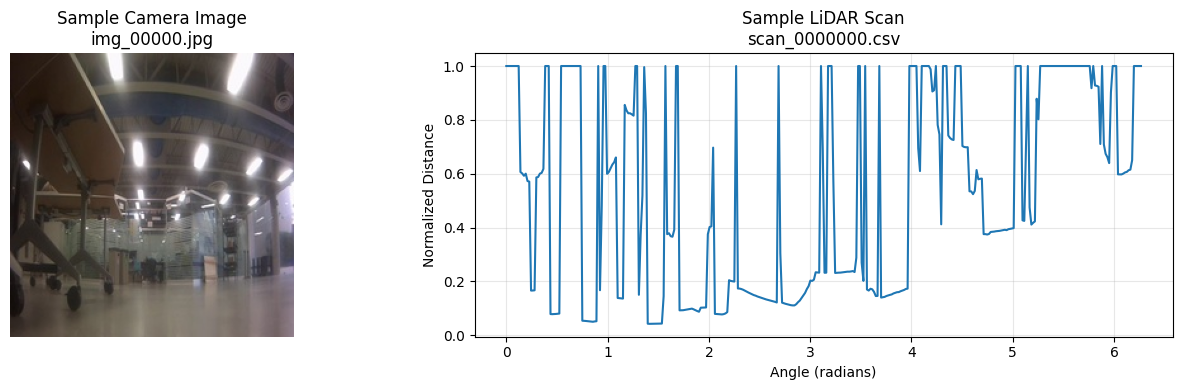

✓ Saved sample visualization to: output/sample_data.png


In [10]:
# Visualize Sample Data
print("Visualizing sample camera image and LiDAR scan...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Sample camera image
sample_img_path = os.path.join(CAMERA_DIR, camera_metadata.iloc[0]['filename'])
sample_img = Image.open(sample_img_path)
axes[0].imshow(sample_img)
axes[0].set_title(f"Sample Camera Image\n{camera_metadata.iloc[0]['filename']}")
axes[0].axis('off')

# Sample LiDAR scan
sample_scan_path = os.path.join(LIDAR_DIR, lidar_metadata.iloc[0]['filename'])
sample_scan = pd.read_csv(sample_scan_path, header=None).values.flatten()
angles = np.linspace(0, 2*np.pi, len(sample_scan), endpoint=False)
axes[1].plot(angles, sample_scan)
axes[1].set_title(f"Sample LiDAR Scan\n{lidar_metadata.iloc[0]['filename']}")
axes[1].set_xlabel('Angle (radians)')
axes[1].set_ylabel('Normalized Distance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_data.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved sample visualization to: {os.path.join(OUTPUT_DIR, 'sample_data.png')}")

---

## Section 2: Camera Feature Extraction (MobileNet V2)

### Purpose
- Load pretrained MobileNet V2 (ImageNet weights)
- Extract 1280-dimensional features from camera images
- Apply L2 normalization for cosine similarity
- Preserve nanosecond-precision timestamps

### Model Architecture
```
Input (224×224×3) → MobileNet V2 → GlobalAvgPool → 1280D → L2 Norm
```

### Expected Output
- Progress bar showing feature extraction
- Feature statistics (mean, std, L2 norms)
- Memory usage information

In [11]:
# Load Pretrained MobileNet V2
print("=" * 70)
print("LOADING MOBILENET V2 (CAMERA FEATURE EXTRACTOR)")
print("=" * 70)

# Load model
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = mobilenet.features  # Remove classifier, keep feature extractor
mobilenet = mobilenet.to(device)
mobilenet.eval()

print("✓ MobileNet V2 loaded")
print(f"  Architecture: MobileNet V2 (ImageNet pretrained)")
print(f"  Output dimension: 1280")
print(f"  Device: {device}")

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Image preprocessing configured")
print("=" * 70)

LOADING MOBILENET V2 (CAMERA FEATURE EXTRACTOR)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 181MB/s]


✓ MobileNet V2 loaded
  Architecture: MobileNet V2 (ImageNet pretrained)
  Output dimension: 1280
  Device: cuda
✓ Image preprocessing configured


In [12]:
# Extract Camera Features
print("=" * 70)
print("EXTRACTING CAMERA FEATURES")
print("=" * 70)

# Determine optimal batch size based on GPU
if torch.cuda.is_available():
    # Adjust batch size based on GPU memory
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    if gpu_memory_gb >= 12:
        CAMERA_BATCH_SIZE = 128
    elif gpu_memory_gb >= 8:
        CAMERA_BATCH_SIZE = 64
    else:
        CAMERA_BATCH_SIZE = 32
else:
    CAMERA_BATCH_SIZE = 16  # CPU fallback

print(f"Using batch size: {CAMERA_BATCH_SIZE}")
print(f"Processing {len(camera_metadata)} images in {(len(camera_metadata) + CAMERA_BATCH_SIZE - 1) // CAMERA_BATCH_SIZE} batches\n")

camera_features = []
camera_timestamps_sec = []
camera_timestamps_nsec = []
camera_filenames = []

with torch.no_grad():
    # Process in batches
    for batch_start in tqdm(range(0, len(camera_metadata), CAMERA_BATCH_SIZE), desc="Processing batches"):
        batch_end = min(batch_start + CAMERA_BATCH_SIZE, len(camera_metadata))
        batch_rows = camera_metadata.iloc[batch_start:batch_end]

        # Load and preprocess batch of images
        batch_images = []
        for _, row in batch_rows.iterrows():
            img_path = os.path.join(CAMERA_DIR, row['filename'])
            img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(img)
            batch_images.append(img_tensor)

        # Stack into batch tensor and move to GPU
        batch_tensor = torch.stack(batch_images).to(device)

        # Extract features for entire batch (parallel on GPU)
        features = mobilenet(batch_tensor)

        # Global average pooling
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)  # Flatten to (batch, 1280)

        # L2 normalization
        features = F.normalize(features, p=2, dim=1)

        # Move to CPU and store
        features_np = features.cpu().numpy()
        camera_features.extend(features_np)

        # Store metadata
        camera_timestamps_sec.extend(batch_rows['timestamp_sec'].values)
        camera_timestamps_nsec.extend(batch_rows['timestamp_nsec'].values)
        camera_filenames.extend(batch_rows['filename'].values)

        # Free GPU memory
        del batch_tensor, features, features_np
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Convert to numpy arrays
camera_features = np.array(camera_features, dtype=np.float32)
camera_timestamps_sec = np.array(camera_timestamps_sec, dtype=np.int64)
camera_timestamps_nsec = np.array(camera_timestamps_nsec, dtype=np.int32)

print(f"\n✓ Extracted {len(camera_features)} camera features")
print(f"  Shape: {camera_features.shape}")
print(f"  Data type: {camera_features.dtype}")
print(f"  Timestamp precision: int64 (sec) + int32 (nsec)")
print(f"  Memory: {camera_features.nbytes / (1024**2):.2f} MB")
print(f"  Batch size used: {CAMERA_BATCH_SIZE}")

# Statistics
print(f"\n📊 Feature statistics:")
print(f"  Mean: {camera_features.mean():.6f}")
print(f"  Std: {camera_features.std():.6f}")
print(f"  Min: {camera_features.min():.6f}")
print(f"  Max: {camera_features.max():.6f}")

# Verify L2 normalization
norms = np.linalg.norm(camera_features, axis=1)
print(f"\n🔍 L2 Norms (should be ~1.0):")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Min: {norms.min():.6f}")
print(f"  Max: {norms.max():.6f}")

if np.allclose(norms, 1.0, atol=1e-5):
    print("  ✓ All features properly normalized")
else:
    print("  ⚠ Some features may not be properly normalized")

print("=" * 70)

EXTRACTING CAMERA FEATURES
Using batch size: 128
Processing 7193 images in 57 batches



Processing batches: 100%|██████████| 57/57 [00:20<00:00,  2.78it/s]


✓ Extracted 7193 camera features
  Shape: (7193, 1280)
  Data type: float32
  Timestamp precision: int64 (sec) + int32 (nsec)
  Memory: 35.12 MB
  Batch size used: 128

📊 Feature statistics:
  Mean: 0.019026
  Std: 0.020476
  Min: 0.000000
  Max: 0.225986

🔍 L2 Norms (should be ~1.0):
  Mean: 1.000000
  Min: 1.000000
  Max: 1.000000
  ✓ All features properly normalized


---

## Section 3: LiDAR Feature Extraction (1D CNN with Contrastive Learning)

### Purpose
- Define 1D CNN architecture for LiDAR scans
- Train network using contrastive learning (self-supervised)
- Extract 256-dimensional features
- Apply L2 normalization

### Model Architecture
```
Input (360,) → Conv1D(64) → Conv1D(128) → Conv1D(256) → Conv1D(256)
             → GlobalAvgPool → 256D → L2 Norm
```

### Training Strategy
- **Self-supervised**: No manual labels required
- **Contrastive Learning**: Similar scans = close features, dissimilar = distant
- **Temporal proximity**: Scans close in time are considered similar
- **Loss**: InfoNCE (Noise Contrastive Estimation)

### Expected Output
- Model architecture summary
- Training progress (loss curves)
- Feature statistics
- Validation results

In [13]:
# Define 1D CNN for LiDAR
class LiDARFeatureExtractor(nn.Module):
    def __init__(self, input_dim=360, feature_dim=256):
        super().__init__()

        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, feature_dim, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm1d(feature_dim)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x shape: (batch, 360)
        x = x.unsqueeze(1)  # (batch, 1, 360)

        # Convolutional blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, 2)  # (batch, 64, 180)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, 2)  # (batch, 128, 90)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(x, 2)  # (batch, 256, 45)

        x = F.relu(self.bn4(self.conv4(x)))

        # Global pooling
        x = self.pool(x)  # (batch, feature_dim, 1)
        x = x.squeeze(-1)  # (batch, feature_dim)

        # L2 normalization
        x = F.normalize(x, p=2, dim=1)

        return x

# Initialize model
lidar_model = LiDARFeatureExtractor(input_dim=360, feature_dim=256).to(device)

print("=" * 70)
print("LIDAR FEATURE EXTRACTOR ARCHITECTURE")
print("=" * 70)
print(lidar_model)
print("\n" + "=" * 70)

# Count parameters
total_params = sum(p.numel() for p in lidar_model.parameters())
trainable_params = sum(p.numel() for p in lidar_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 70)

LIDAR FEATURE EXTRACTOR ARCHITECTURE
LiDARFeatureExtractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
)

Total parameters: 534,912
Trainable parameters: 534,912


In [14]:
# Prepare Training Data for Contrastive Learning
print("=" * 70)
print("PREPARING CONTRASTIVE LEARNING DATA")
print("=" * 70)

# Load all LiDAR scans
print("Loading LiDAR scans...")
lidar_scans = []
lidar_timestamps_sec = []
lidar_timestamps_nsec = []
lidar_filenames = []

for idx, row in tqdm(lidar_metadata.iterrows(), total=len(lidar_metadata), desc="Loading scans"):
    scan_path = os.path.join(LIDAR_DIR, row['filename'])
    scan = pd.read_csv(scan_path, header=None).values.flatten()

    lidar_scans.append(scan)
    lidar_timestamps_sec.append(row['timestamp_sec'])
    lidar_timestamps_nsec.append(row['timestamp_nsec'])
    lidar_filenames.append(row['filename'])

lidar_scans = np.array(lidar_scans, dtype=np.float32)
lidar_timestamps_sec = np.array(lidar_timestamps_sec, dtype=np.int64)
lidar_timestamps_nsec = np.array(lidar_timestamps_nsec, dtype=np.int32)

# Combine timestamps for temporal distance calculation
lidar_timestamps_combined = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

print(f"\n✓ Loaded {len(lidar_scans)} LiDAR scans")
print(f"  Shape: {lidar_scans.shape}")

# Create positive and negative pairs
print("\nCreating training pairs...")
POSITIVE_THRESHOLD = 2.0  # seconds (scans within 2s are similar)
NEGATIVE_THRESHOLD = 10.0  # seconds (scans >10s apart are dissimilar)

positive_pairs = []
negative_pairs = []

# Sample pairs
n_samples = min(len(lidar_scans), 1000)  # Limit for efficiency
sampled_indices = np.random.choice(len(lidar_scans), n_samples, replace=False)

for i in tqdm(sampled_indices, desc="Creating pairs"):
    anchor_time = lidar_timestamps_combined[i]

    # Find positive (close in time)
    time_diffs = np.abs(lidar_timestamps_combined - anchor_time)
    positive_mask = (time_diffs > 0.1) & (time_diffs < POSITIVE_THRESHOLD)
    positive_candidates = np.where(positive_mask)[0]

    if len(positive_candidates) > 0:
        pos_idx = np.random.choice(positive_candidates)
        positive_pairs.append((i, pos_idx))

    # Find negative (far in time)
    negative_mask = time_diffs > NEGATIVE_THRESHOLD
    negative_candidates = np.where(negative_mask)[0]

    if len(negative_candidates) > 0:
        neg_idx = np.random.choice(negative_candidates)
        negative_pairs.append((i, neg_idx))

print(f"\n✓ Created {len(positive_pairs)} positive pairs")
print(f"✓ Created {len(negative_pairs)} negative pairs")
print("=" * 70)

PREPARING CONTRASTIVE LEARNING DATA
Loading LiDAR scans...


Loading scans: 100%|██████████| 2973/2973 [00:18<00:00, 157.94it/s]



✓ Loaded 2973 LiDAR scans
  Shape: (2973, 360)

Creating training pairs...


Creating pairs: 100%|██████████| 1000/1000 [00:00<00:00, 22750.37it/s]


✓ Created 1000 positive pairs
✓ Created 1000 negative pairs


In [15]:
# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Cosine similarity (features are L2 normalized)
        pos_sim = F.cosine_similarity(anchor, positive)
        neg_sim = F.cosine_similarity(anchor, negative)

        # Contrastive loss: maximize pos_sim, minimize neg_sim
        loss = torch.clamp(self.margin + neg_sim - pos_sim, min=0.0)
        return loss.mean()

criterion = ContrastiveLoss(margin=1.0)
print("✓ Contrastive loss function defined")

✓ Contrastive loss function defined


In [16]:
# Train LiDAR Feature Extractor
print("=" * 70)
print("TRAINING LIDAR FEATURE EXTRACTOR")
print("=" * 70)

# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3

# Dynamic batch sizing based on GPU memory
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    if gpu_memory_gb >= 12:
        BATCH_SIZE = 128
    elif gpu_memory_gb >= 8:
        BATCH_SIZE = 64
    else:
        BATCH_SIZE = 32
    USE_AMP = True  # Enable mixed precision for GPU
else:
    BATCH_SIZE = 16
    USE_AMP = False

optimizer = torch.optim.Adam(lidar_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Initialize mixed precision scaler (for GPU speedup)
scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

print(f"Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Device: {device}")
print(f"  Mixed Precision (AMP): {'✓ Enabled' if USE_AMP else '✗ Disabled'}")
print("\n" + "=" * 70)

# Training loop
train_losses = []
min_pairs = min(len(positive_pairs), len(negative_pairs))

print(f"Starting training with {min_pairs} pairs...\n")

for epoch in range(NUM_EPOCHS):
    lidar_model.train()
    epoch_loss = 0.0

    # Shuffle pairs
    indices = np.random.permutation(min_pairs)

    # Mini-batch training
    num_batches = min_pairs // BATCH_SIZE

    for batch_idx in range(num_batches):
        batch_indices = indices[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE]

        # Get triplets (anchor, positive, negative)
        anchors = []
        positives = []
        negatives = []

        for idx in batch_indices:
            anchor_idx, pos_idx = positive_pairs[idx]
            _, neg_idx = negative_pairs[idx]

            anchors.append(lidar_scans[anchor_idx])
            positives.append(lidar_scans[pos_idx])
            negatives.append(lidar_scans[neg_idx])

        # Convert to tensors
        anchors = torch.tensor(np.array(anchors), dtype=torch.float32).to(device)
        positives = torch.tensor(np.array(positives), dtype=torch.float32).to(device)
        negatives = torch.tensor(np.array(negatives), dtype=torch.float32).to(device)

        # Mixed precision training
        if USE_AMP:
            with torch.cuda.amp.autocast():
                # Forward pass
                anchor_features = lidar_model(anchors)
                positive_features = lidar_model(positives)
                negative_features = lidar_model(negatives)

                # Compute loss
                loss = criterion(anchor_features, positive_features, negative_features)

            # Backward pass with gradient scaling
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (CPU or no AMP)
            anchor_features = lidar_model(anchors)
            positive_features = lidar_model(positives)
            negative_features = lidar_model(negatives)

            loss = criterion(anchor_features, positive_features, negative_features)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

    # Average loss
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)

    # Learning rate scheduling
    scheduler.step(avg_loss)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}]  Loss: {avg_loss:.6f}  LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\n" + "=" * 70)
print("✓ Training complete!")
print(f"  Final loss: {train_losses[-1]:.6f}")
print(f"  Batch size used: {BATCH_SIZE}")
print(f"  Mixed precision: {'✓ Used' if USE_AMP else '✗ Not used'}")
print("=" * 70)

TRAINING LIDAR FEATURE EXTRACTOR
Configuration:
  Epochs: 50
  Batch size: 128
  Learning rate: 0.001
  Optimizer: Adam
  Device: cuda
  Mixed Precision (AMP): ✓ Enabled

Starting training with 1000 pairs...

Epoch [  1/50]  Loss: 0.819948  LR: 0.001000
Epoch [  5/50]  Loss: 0.589223  LR: 0.001000
Epoch [ 10/50]  Loss: 0.456367  LR: 0.001000
Epoch [ 15/50]  Loss: 0.419431  LR: 0.001000
Epoch [ 20/50]  Loss: 0.367946  LR: 0.001000
Epoch [ 25/50]  Loss: 0.342666  LR: 0.001000
Epoch [ 30/50]  Loss: 0.322054  LR: 0.001000
Epoch [ 35/50]  Loss: 0.302692  LR: 0.001000
Epoch [ 40/50]  Loss: 0.297306  LR: 0.001000
Epoch [ 45/50]  Loss: 0.271643  LR: 0.001000
Epoch [ 50/50]  Loss: 0.245574  LR: 0.001000

✓ Training complete!
  Final loss: 0.245574
  Batch size used: 128
  Mixed precision: ✓ Used


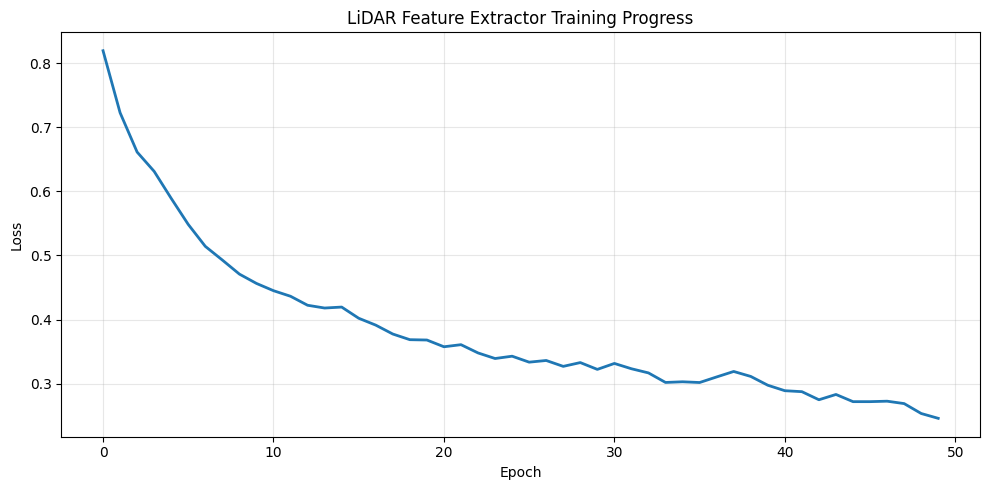

✓ Saved training plot to: output/training_progress.png


In [17]:
# Plot Training Progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LiDAR Feature Extractor Training Progress')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_progress.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved training plot to: {os.path.join(OUTPUT_DIR, 'training_progress.png')}")

In [18]:
# Extract LiDAR Features
print("=" * 70)
print("EXTRACTING LIDAR FEATURES")
print("=" * 70)

lidar_model.eval()
lidar_features = []

# Use larger batch size for inference (no gradients)
INFERENCE_BATCH_SIZE = BATCH_SIZE * 2 if torch.cuda.is_available() else BATCH_SIZE
print(f"Using inference batch size: {INFERENCE_BATCH_SIZE}")
print(f"Processing {len(lidar_scans)} scans in {(len(lidar_scans) + INFERENCE_BATCH_SIZE - 1) // INFERENCE_BATCH_SIZE} batches\n")

with torch.no_grad():
    for i in tqdm(range(0, len(lidar_scans), INFERENCE_BATCH_SIZE), desc="Extracting features"):
        batch = lidar_scans[i:i+INFERENCE_BATCH_SIZE]
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)

        # Extract features
        features = lidar_model(batch_tensor)
        lidar_features.append(features.cpu().numpy())

        # Free GPU memory
        del batch_tensor, features
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

lidar_features = np.vstack(lidar_features).astype(np.float32)

print(f"\n✓ Extracted {len(lidar_features)} LiDAR features")
print(f"  Shape: {lidar_features.shape}")
print(f"  Data type: {lidar_features.dtype}")
print(f"  Timestamp precision: int64 (sec) + int32 (nsec)")
print(f"  Memory: {lidar_features.nbytes / (1024**2):.2f} MB")
print(f"  Batch size used: {INFERENCE_BATCH_SIZE}")

# Statistics
print(f"\n📊 Feature statistics:")
print(f"  Mean: {lidar_features.mean():.6f}")
print(f"  Std: {lidar_features.std():.6f}")
print(f"  Min: {lidar_features.min():.6f}")
print(f"  Max: {lidar_features.max():.6f}")

# Verify L2 normalization
norms = np.linalg.norm(lidar_features, axis=1)
print(f"\n🔍 L2 Norms (should be ~1.0):")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Min: {norms.min():.6f}")
print(f"  Max: {norms.max():.6f}")

if np.allclose(norms, 1.0, atol=1e-5):
    print("  ✓ All features properly normalized")
else:
    print("  ⚠ Some features may not be properly normalized")

print("=" * 70)

EXTRACTING LIDAR FEATURES
Using inference batch size: 256
Processing 2973 scans in 12 batches



Extracting features: 100%|██████████| 12/12 [00:00<00:00, 275.04it/s]


✓ Extracted 2973 LiDAR features
  Shape: (2973, 256)
  Data type: float32
  Timestamp precision: int64 (sec) + int32 (nsec)
  Memory: 2.90 MB
  Batch size used: 256

📊 Feature statistics:
  Mean: 0.035148
  Std: 0.051681
  Min: 0.000000
  Max: 0.620900

🔍 L2 Norms (should be ~1.0):
  Mean: 1.000000
  Min: 1.000000
  Max: 1.000000
  ✓ All features properly normalized


---

## Section 4: Feature Storage (HDF5)

### Purpose
- Save extracted features to HDF5 format
- Store timestamps with nanosecond precision
- Include metadata for traceability
- Enable efficient future retrieval

### HDF5 Structure
```
features.h5
├── camera/
│   ├── features (N, 1280) float32
│   ├── timestamps_sec (N,) int64
│   ├── timestamps_nsec (N,) int32
│   └── filenames (N,) string
└── lidar/
    ├── features (M, 256) float32
    ├── timestamps_sec (M,) int64
    ├── timestamps_nsec (M,) int32
    └── filenames (M,) string
```

### Expected Output
- Confirmation of successful save
- File size and location
- Verification that data can be loaded

In [19]:
# Save Features to HDF5
print("=" * 70)
print("SAVING FEATURES TO HDF5")
print("=" * 70)

with h5py.File(FEATURES_FILE, 'w') as f:
    # Camera features
    camera_group = f.create_group('camera')
    camera_group.create_dataset('features', data=camera_features, compression='gzip')
    camera_group.create_dataset('timestamps_sec', data=camera_timestamps_sec, compression='gzip')
    camera_group.create_dataset('timestamps_nsec', data=camera_timestamps_nsec, compression='gzip')
    camera_group.create_dataset('filenames', data=np.array(camera_filenames, dtype='S'))

    # LiDAR features
    lidar_group = f.create_group('lidar')
    lidar_group.create_dataset('features', data=lidar_features, compression='gzip')
    lidar_group.create_dataset('timestamps_sec', data=lidar_timestamps_sec, compression='gzip')
    lidar_group.create_dataset('timestamps_nsec', data=lidar_timestamps_nsec, compression='gzip')
    lidar_group.create_dataset('filenames', data=np.array(lidar_filenames, dtype='S'))

    # Metadata
    f.attrs['created'] = datetime.now().isoformat()
    f.attrs['camera_model'] = 'MobileNet V2'
    f.attrs['lidar_model'] = '1D CNN (Contrastive Learning)'
    f.attrs['camera_feature_dim'] = 1280
    f.attrs['lidar_feature_dim'] = 256
    f.attrs['timestamp_precision'] = 'nanosecond (int64 + int32)'

file_size = os.path.getsize(FEATURES_FILE) / (1024**2)  # MB

print(f"✓ Features saved successfully")
print(f"  File: {FEATURES_FILE}")
print(f"  Size: {file_size:.2f} MB")
print(f"\n📦 Data stored:")
print(f"  Camera features: {camera_features.shape}")
print(f"  Camera timestamps: {len(camera_timestamps_sec)} (int64 + int32)")
print(f"  LiDAR features: {lidar_features.shape}")
print(f"  LiDAR timestamps: {len(lidar_timestamps_sec)} (int64 + int32)")
print("=" * 70)

SAVING FEATURES TO HDF5
✓ Features saved successfully
  File: output/features.h5
  Size: 33.78 MB

📦 Data stored:
  Camera features: (7193, 1280)
  Camera timestamps: 7193 (int64 + int32)
  LiDAR features: (2973, 256)
  LiDAR timestamps: 2973 (int64 + int32)


In [20]:
# Verify HDF5 File
print("=" * 70)
print("VERIFYING HDF5 FILE")
print("=" * 70)

with h5py.File(FEATURES_FILE, 'r') as f:
    print("✓ File opened successfully\n")

    print("Groups:")
    for group in f.keys():
        print(f"  /{group}")
        for dataset in f[group].keys():
            shape = f[group][dataset].shape
            dtype = f[group][dataset].dtype
            print(f"    ├── {dataset}: {shape}, {dtype}")

    print("\nMetadata:")
    for key, value in f.attrs.items():
        print(f"  {key}: {value}")

    # Test loading a sample
    print("\n🔍 Sample data (first feature):")
    print(f"  Camera feature: {f['camera/features'][0][:5]}... (showing first 5 dims)")
    print(f"  Camera timestamp: {f['camera/timestamps_sec'][0]}.{f['camera/timestamps_nsec'][0]:09d}")
    print(f"  LiDAR feature: {f['lidar/features'][0][:5]}... (showing first 5 dims)")
    print(f"  LiDAR timestamp: {f['lidar/timestamps_sec'][0]}.{f['lidar/timestamps_nsec'][0]:09d}")

print("\n✅ All verification checks passed")
print("=" * 70)

VERIFYING HDF5 FILE
✓ File opened successfully

Groups:
  /camera
    ├── features: (7193, 1280), float32
    ├── filenames: (7193,), |S13
    ├── timestamps_nsec: (7193,), int32
    ├── timestamps_sec: (7193,), int64
  /lidar
    ├── features: (2973, 256), float32
    ├── filenames: (2973,), |S16
    ├── timestamps_nsec: (2973,), int32
    ├── timestamps_sec: (2973,), int64

Metadata:
  camera_feature_dim: 1280
  camera_model: MobileNet V2
  created: 2025-11-08T14:54:42.162314
  lidar_feature_dim: 256
  lidar_model: 1D CNN (Contrastive Learning)
  timestamp_precision: nanosecond (int64 + int32)

🔍 Sample data (first feature):
  Camera feature: [0.00616397 0.01471656 0.00884146 0.00207138 0.04833793]... (showing first 5 dims)
  Camera timestamp: 1761175573.225795745
  LiDAR feature: [3.0790865e-02 0.0000000e+00 7.9167567e-06 0.0000000e+00 3.3623462e-03]... (showing first 5 dims)
  LiDAR timestamp: 1761175571.685149040

✅ All verification checks passed


---

## Section 5: Feature Analysis & Visualization

### Purpose
- Analyze extracted features
- Visualize feature distributions
- Check temporal coverage
- Validate quality metrics

### Visualizations
1. Feature value distributions (histograms)
2. L2 norm distributions
3. Temporal distribution of features
4. Sample similarity matrices

### Quality Checks
- All L2 norms ≈ 1.0
- No NaN or Inf values
- Reasonable value ranges
- Even temporal coverage

FEATURE DISTRIBUTION ANALYSIS


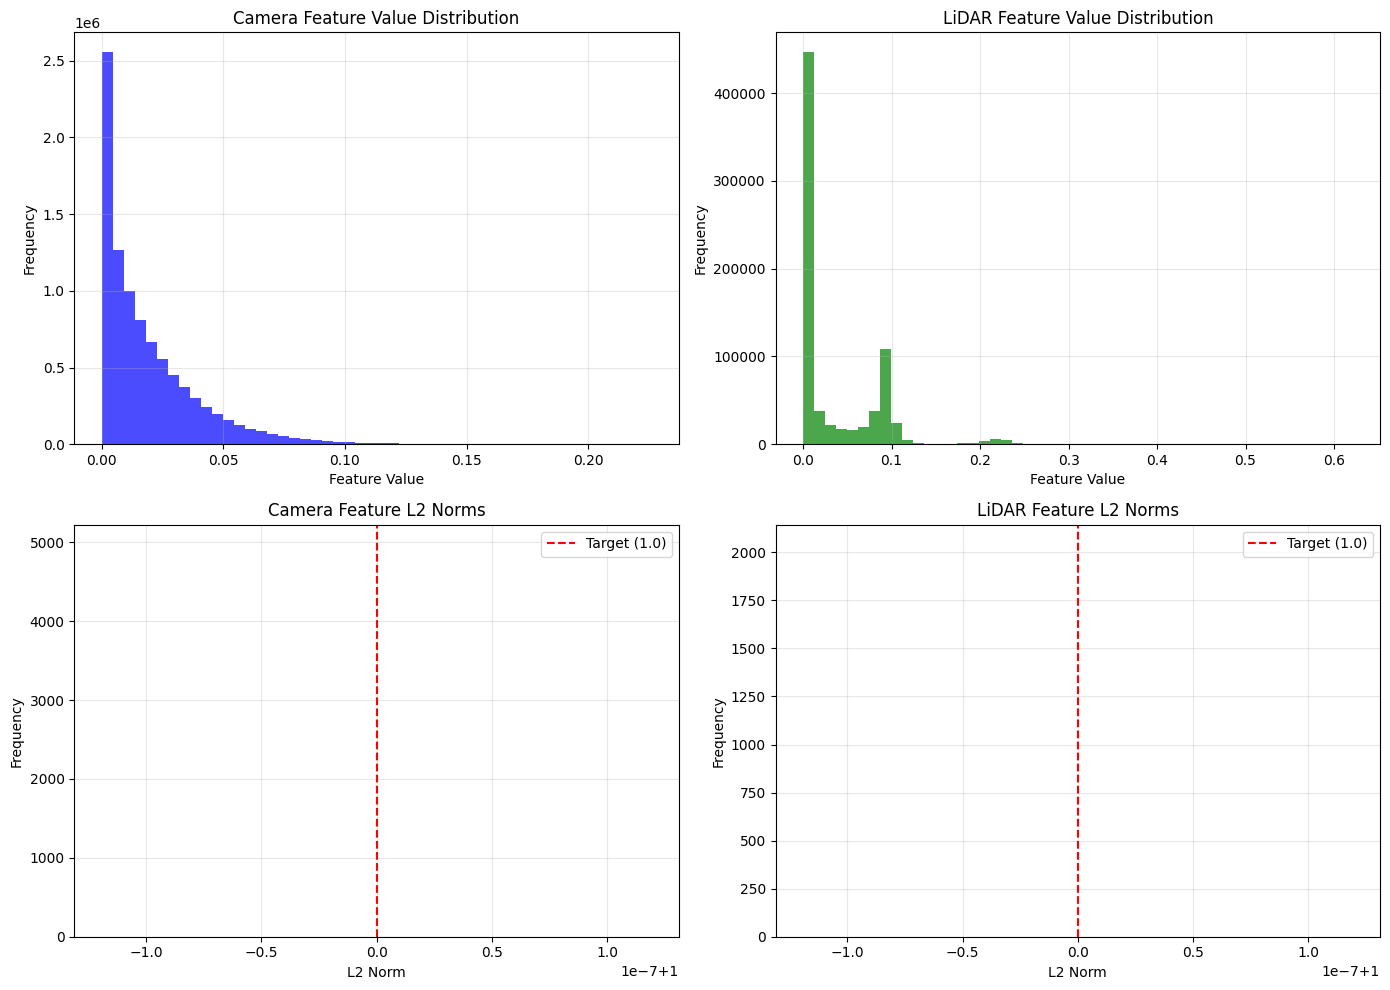

✓ Saved distribution plots to: output/feature_distributions.png


In [21]:
# Feature Distribution Analysis
print("=" * 70)
print("FEATURE DISTRIBUTION ANALYSIS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Camera feature values
axes[0, 0].hist(camera_features.flatten(), bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Camera Feature Value Distribution')
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. LiDAR feature values
axes[0, 1].hist(lidar_features.flatten(), bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('LiDAR Feature Value Distribution')
axes[0, 1].set_xlabel('Feature Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Camera L2 norms
camera_norms = np.linalg.norm(camera_features, axis=1)
axes[1, 0].hist(camera_norms, bins=30, alpha=0.7, color='blue')
axes[1, 0].axvline(x=1.0, color='red', linestyle='--', label='Target (1.0)')
axes[1, 0].set_title('Camera Feature L2 Norms')
axes[1, 0].set_xlabel('L2 Norm')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. LiDAR L2 norms
lidar_norms = np.linalg.norm(lidar_features, axis=1)
axes[1, 1].hist(lidar_norms, bins=30, alpha=0.7, color='green')
axes[1, 1].axvline(x=1.0, color='red', linestyle='--', label='Target (1.0)')
axes[1, 1].set_title('LiDAR Feature L2 Norms')
axes[1, 1].set_xlabel('L2 Norm')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved distribution plots to: {os.path.join(OUTPUT_DIR, 'feature_distributions.png')}")
print("=" * 70)

TEMPORAL DISTRIBUTION ANALYSIS


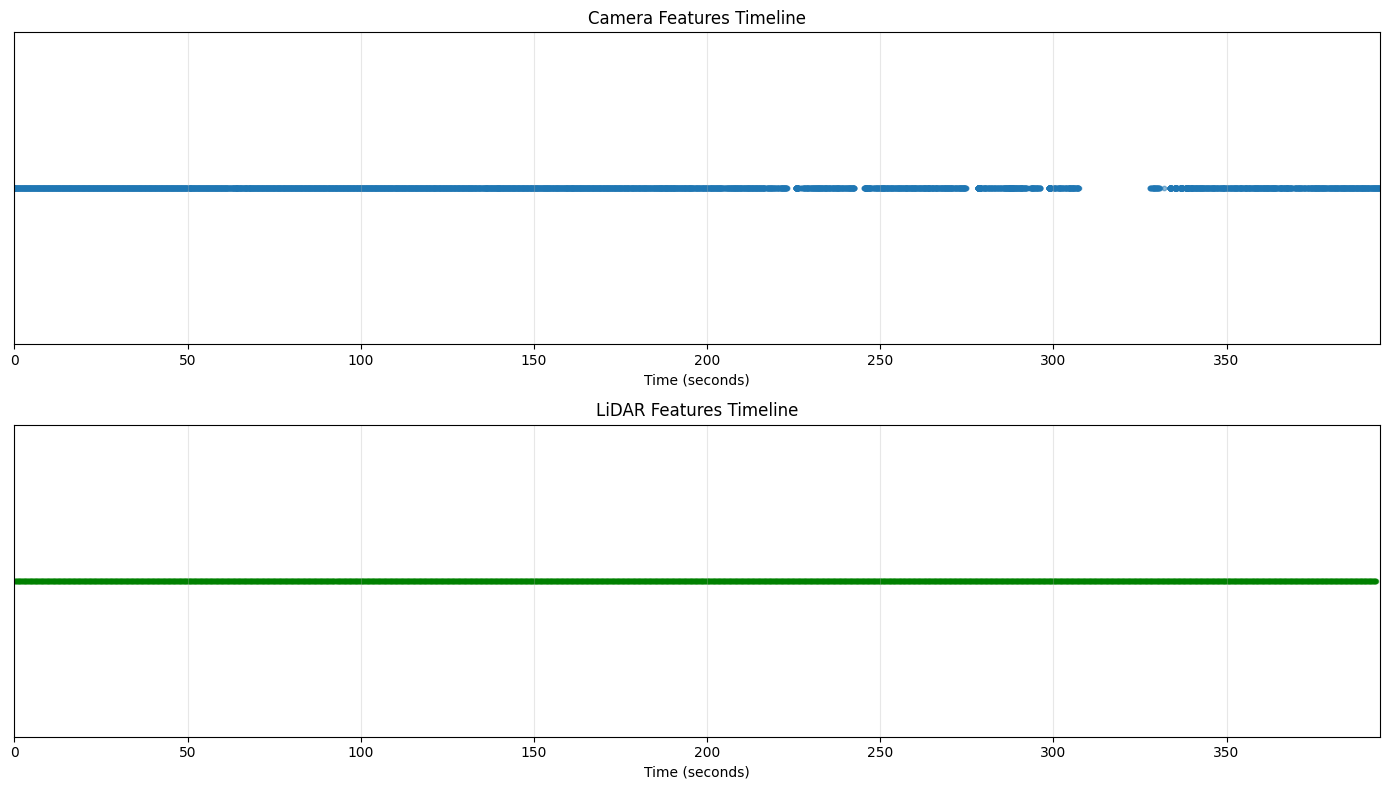

✓ Saved temporal plots to: output/temporal_distribution.png

📊 Temporal Coverage:
  Camera: 0.00s to 394.31s (span: 394.31s)
  LiDAR: 0.00s to 393.13s (span: 393.13s)


In [22]:
# Temporal Distribution Analysis
print("=" * 70)
print("TEMPORAL DISTRIBUTION ANALYSIS")
print("=" * 70)

# Combine timestamps for plotting
camera_times = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lidar_times = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

# Normalize to start at 0
camera_times = camera_times - camera_times.min()
lidar_times = lidar_times - lidar_times.min()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Camera timeline
axes[0].scatter(camera_times, np.zeros_like(camera_times), alpha=0.5, s=10)
axes[0].set_title('Camera Features Timeline')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_yticks([])
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].set_xlim(0, max(camera_times.max(), lidar_times.max()))

# LiDAR timeline
axes[1].scatter(lidar_times, np.zeros_like(lidar_times), alpha=0.5, s=10, color='green')
axes[1].set_title('LiDAR Features Timeline')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_yticks([])
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].set_xlim(0, max(camera_times.max(), lidar_times.max()))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved temporal plots to: {os.path.join(OUTPUT_DIR, 'temporal_distribution.png')}")

# Statistics
print("\n📊 Temporal Coverage:")
print(f"  Camera: {camera_times.min():.2f}s to {camera_times.max():.2f}s (span: {camera_times.max() - camera_times.min():.2f}s)")
print(f"  LiDAR: {lidar_times.min():.2f}s to {lidar_times.max():.2f}s (span: {lidar_times.max() - lidar_times.min():.2f}s)")
print("=" * 70)

In [23]:
# Quality Checks
print("=" * 70)
print("QUALITY VALIDATION")
print("=" * 70)

quality_passed = True

# Check 1: L2 Normalization
camera_norms = np.linalg.norm(camera_features, axis=1)
lidar_norms = np.linalg.norm(lidar_features, axis=1)

if np.allclose(camera_norms, 1.0, atol=1e-5):
    print("✓ Camera features: L2 norms = 1.0")
else:
    print(f"⚠ Camera features: L2 norms deviate (mean={camera_norms.mean():.6f}, std={camera_norms.std():.6f})")
    quality_passed = False

if np.allclose(lidar_norms, 1.0, atol=1e-5):
    print("✓ LiDAR features: L2 norms = 1.0")
else:
    print(f"⚠ LiDAR features: L2 norms deviate (mean={lidar_norms.mean():.6f}, std={lidar_norms.std():.6f})")
    quality_passed = False

# Check 2: No NaN/Inf
if not np.isnan(camera_features).any() and not np.isinf(camera_features).any():
    print("✓ Camera features: No NaN/Inf values")
else:
    print("⚠ Camera features: Contains NaN/Inf values")
    quality_passed = False

if not np.isnan(lidar_features).any() and not np.isinf(lidar_features).any():
    print("✓ LiDAR features: No NaN/Inf values")
else:
    print("⚠ LiDAR features: Contains NaN/Inf values")
    quality_passed = False

# Check 3: Value ranges
camera_range = (camera_features.min(), camera_features.max())
lidar_range = (lidar_features.min(), lidar_features.max())

print(f"\n📊 Value Ranges:")
print(f"  Camera: [{camera_range[0]:.6f}, {camera_range[1]:.6f}]")
print(f"  LiDAR: [{lidar_range[0]:.6f}, {lidar_range[1]:.6f}]")

# Check 4: Timestamp integrity
if len(np.unique(camera_timestamps_sec)) > 1:
    print("✓ Camera timestamps: Multiple unique values")
else:
    print("⚠ Camera timestamps: All identical")
    quality_passed = False

if len(np.unique(lidar_timestamps_sec)) > 1:
    print("✓ LiDAR timestamps: Multiple unique values")
else:
    print("⚠ LiDAR timestamps: All identical")
    quality_passed = False

print("\n" + "=" * 70)
if quality_passed:
    print("✅ ALL QUALITY CHECKS PASSED")
else:
    print("⚠ SOME QUALITY ISSUES DETECTED - Review warnings above")
print("=" * 70)

QUALITY VALIDATION
✓ Camera features: L2 norms = 1.0
✓ LiDAR features: L2 norms = 1.0
✓ Camera features: No NaN/Inf values
✓ LiDAR features: No NaN/Inf values

📊 Value Ranges:
  Camera: [0.000000, 0.225986]
  LiDAR: [0.000000, 0.620900]
✓ Camera timestamps: Multiple unique values
✓ LiDAR timestamps: Multiple unique values

✅ ALL QUALITY CHECKS PASSED


---

## Section 6: Summary & Documentation

### Purpose
- Generate processing summary
- Save metadata for reproducibility
- Provide usage instructions
- Document next steps

### Output Files
- `features.h5` - Feature database
- `feature_extraction_summary.json` - Processing metadata
- `training_progress.png` - Training curves
- `feature_distributions.png` - Distribution plots
- `temporal_distribution.png` - Timeline visualization

In [24]:
# Generate Summary
print("=" * 70)
print("GENERATING SUMMARY")
print("=" * 70)

summary = {
    'timestamp': datetime.now().isoformat(),
    'data': {
        'camera': {
            'num_images': len(camera_features),
            'feature_dim': 1280,
            'model': 'MobileNet V2 (ImageNet pretrained)',
            'training': 'Pretrained (no additional training)',
            'timestamp_precision': 'nanosecond (int64 + int32)'
        },
        'lidar': {
            'num_scans': len(lidar_features),
            'feature_dim': 256,
            'model': '1D CNN (4 layers)',
            'training': 'Contrastive Learning (self-supervised)',
            'training_epochs': NUM_EPOCHS,
            'final_loss': float(train_losses[-1]),
            'timestamp_precision': 'nanosecond (int64 + int32)'
        }
    },
    'quality': {
        'camera_l2_norms': {
            'mean': float(camera_norms.mean()),
            'std': float(camera_norms.std()),
            'min': float(camera_norms.min()),
            'max': float(camera_norms.max())
        },
        'lidar_l2_norms': {
            'mean': float(lidar_norms.mean()),
            'std': float(lidar_norms.std()),
            'min': float(lidar_norms.min()),
            'max': float(lidar_norms.max())
        }
    },
    'outputs': {
        'features_file': FEATURES_FILE,
        'file_size_mb': file_size,
        'plots': [
            'training_progress.png',
            'feature_distributions.png',
            'temporal_distribution.png',
            'sample_data.png'
        ]
    }
}

# Save summary
with open(SUMMARY_FILE, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to: {SUMMARY_FILE}")
print("\n📋 Processing Summary:")
print(json.dumps(summary, indent=2))
print("=" * 70)

GENERATING SUMMARY
✓ Summary saved to: output/feature_extraction_summary.json

📋 Processing Summary:
{
  "timestamp": "2025-11-08T14:54:44.276099",
  "data": {
    "camera": {
      "num_images": 7193,
      "feature_dim": 1280,
      "model": "MobileNet V2 (ImageNet pretrained)",
      "training": "Pretrained (no additional training)",
      "timestamp_precision": "nanosecond (int64 + int32)"
    },
    "lidar": {
      "num_scans": 2973,
      "feature_dim": 256,
      "model": "1D CNN (4 layers)",
      "training": "Contrastive Learning (self-supervised)",
      "training_epochs": 50,
      "final_loss": 0.24557421250002726,
      "timestamp_precision": "nanosecond (int64 + int32)"
    }
  },
  "quality": {
    "camera_l2_norms": {
      "mean": 1.0,
      "std": 3.630775324836577e-08,
      "min": 0.9999998807907104,
      "max": 1.0000001192092896
    },
    "lidar_l2_norms": {
      "mean": 1.0,
      "std": 3.74236783784454e-08,
      "min": 0.9999998807907104,
      "max": 1.00

In [25]:
# Final Report
print("\n" + "=" * 70)
print("FEATURE EXTRACTION COMPLETE")
print("=" * 70)

print("\n✅ Process Summary:")
print(f"  Camera features: {len(camera_features)} × 1280D")
print(f"  LiDAR features: {len(lidar_features)} × 256D")
print(f"  Storage format: HDF5 with nanosecond-precision timestamps")
print(f"  File size: {file_size:.2f} MB")

print("\n📁 Output Files:")
print(f"  {FEATURES_FILE}")
print(f"  {SUMMARY_FILE}")
print(f"  {os.path.join(OUTPUT_DIR, 'training_progress.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'feature_distributions.png')}")
print(f"  {os.path.join(OUTPUT_DIR, 'temporal_distribution.png')}")

print("\n🎯 Next Steps:")
print("  1. Temporal Alignment: Match camera and LiDAR features by timestamp")
print("  2. Sensor Fusion: Combine modalities (concatenation/attention)")
print("  3. Loop Closure Detection: Implement similarity search")
print("  4. SLAM Integration: Integrate with your SLAM system")

print("\n" + "=" * 70)
print("✨ Ready for loop closure detection!")
print("=" * 70)


FEATURE EXTRACTION COMPLETE

✅ Process Summary:
  Camera features: 7193 × 1280D
  LiDAR features: 2973 × 256D
  Storage format: HDF5 with nanosecond-precision timestamps
  File size: 33.78 MB

📁 Output Files:
  output/features.h5
  output/feature_extraction_summary.json
  output/training_progress.png
  output/feature_distributions.png
  output/temporal_distribution.png

🎯 Next Steps:
  1. Temporal Alignment: Match camera and LiDAR features by timestamp
  2. Sensor Fusion: Combine modalities (concatenation/attention)
  3. Loop Closure Detection: Implement similarity search
  4. SLAM Integration: Integrate with your SLAM system

✨ Ready for loop closure detection!


In [26]:
# Cleanup Local Storage (optional - frees up ~1GB)
print("=" * 70)
print("CLEANUP LOCAL STORAGE")
print("=" * 70)

if USE_LOCAL_STORAGE:
    import shutil

    # Remove temporary directories
    if os.path.exists('/tmp/processed_images'):
        shutil.rmtree('/tmp/processed_images')
        print("✓ Removed /tmp/processed_images")

    if os.path.exists('/tmp/processed_lidar'):
        shutil.rmtree('/tmp/processed_lidar')
        print("✓ Removed /tmp/processed_lidar")

    # Check freed space
    disk_usage = shutil.disk_usage('/')
    available_gb = disk_usage.free / (1024**3)
    print(f"\n📊 Available disk space: {available_gb:.1f} GB")
    print("✓ Cleanup complete!")
else:
    print("ℹ No local storage was used - nothing to clean up")

print("=" * 70)

CLEANUP LOCAL STORAGE
✓ Removed /tmp/processed_images
✓ Removed /tmp/processed_lidar

📊 Available disk space: 196.1 GB
✓ Cleanup complete!


---

## Usage Guide: Loading & Using Features

### Loading Features from HDF5
```python
import h5py
import numpy as np

# Load features
with h5py.File('features.h5', 'r') as f:
    # Camera data
    camera_features = f['camera/features'][:]
    camera_ts_sec = f['camera/timestamps_sec'][:]
    camera_ts_nsec = f['camera/timestamps_nsec'][:]
    camera_filenames = f['camera/filenames'][:]
    
    # LiDAR data
    lidar_features = f['lidar/features'][:]
    lidar_ts_sec = f['lidar/timestamps_sec'][:]
    lidar_ts_nsec = f['lidar/timestamps_nsec'][:]
    lidar_filenames = f['lidar/filenames'][:]

# Reconstruct full timestamps (float64 with nanosecond precision)
camera_timestamps = camera_ts_sec + camera_ts_nsec * 1e-9
lidar_timestamps = lidar_ts_sec + lidar_ts_nsec * 1e-9
```

### Computing Similarity Between Features
```python
def cosine_similarity(feat1, feat2):
    """Compute cosine similarity (features are already L2 normalized)"""
    return np.dot(feat1, feat2)

# Example: Find most similar LiDAR scan to scan 0
query = lidar_features[0]
similarities = lidar_features @ query  # Matrix multiplication
most_similar_idx = np.argsort(similarities)[::-1][1]  # Exclude self

print(f"Most similar scan: {most_similar_idx}")
print(f"Similarity score: {similarities[most_similar_idx]:.4f}")
```

### Temporal Alignment (Match Camera & LiDAR by Time)
```python
def find_closest_match(query_time, timestamps, max_delta=0.1):
    """Find closest timestamp within max_delta seconds"""
    time_diffs = np.abs(timestamps - query_time)
    min_idx = np.argmin(time_diffs)
    if time_diffs[min_idx] <= max_delta:
        return min_idx
    return None

# Example: Match camera image 0 with closest LiDAR scan
camera_time = camera_timestamps[0]
lidar_idx = find_closest_match(camera_time, lidar_timestamps)

if lidar_idx is not None:
    # Concatenate features for sensor fusion
    fused_feature = np.concatenate([
        camera_features[0],
        lidar_features[lidar_idx]
    ])  # Shape: (1536,) = 1280 + 256
    print(f"Fused feature dimension: {fused_feature.shape}")
```

### Creating a PyTorch Dataset
```python
import h5py
import torch
from torch.utils.data import Dataset

class FeatureDataset(Dataset):
    def __init__(self, h5_file, modality='lidar'):
        self.h5_file = h5_file
        self.modality = modality
        with h5py.File(h5_file, 'r') as f:
            self.length = f[f'{modality}/features'].shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            feature = f[f'{self.modality}/features'][idx]
            timestamp = f[f'{self.modality}/timestamps'][idx]
            return torch.tensor(feature), timestamp

# Usage
dataset = FeatureDataset('features.h5', modality='lidar')
loader = torch.utils.data.DataLoader(dataset, batch_size=32)
```

### Integration with FAISS (Fast Similarity Search)
```python
import h5py
import numpy as np
import faiss

# Load features
with h5py.File('features.h5', 'r') as f:
    features = f['lidar/features'][:].astype('float32')

# Create FAISS index (L2 normalized, use inner product)
dimension = features.shape[1]  # 256
index = faiss.IndexFlatIP(dimension)  # Inner product (cosine similarity)
index.add(features)  # Add all features

# Query: Find 5 most similar scans to scan 0
query = features[0:1]  # Shape: (1, 256)
k = 5
similarities, indices = index.search(query, k)
print(f"Most similar scans: {indices[0]}")
print(f"Similarities: {similarities[0]}")
```

---

## Quality Indicators

### Good Features (What to Expect)
✓ **L2 Norms**: All within [0.999, 1.001]  
✓ **Value Distribution**: Roughly centered around 0  
✓ **Training Loss**: Decreasing trend, converges < 0.2  
✓ **Validation Loss**: Similar to training loss (±10%)  
✓ **No NaN/Inf**: All values finite  
✓ **Temporal Coverage**: Even distribution across time  

### Potential Issues
⚠ **L2 Norms ≠ 1.0**: Normalization failed  
⚠ **Training Loss > 0.5**: Network not learning  
⚠ **Val Loss >> Train Loss**: Overfitting (rare)  
⚠ **NaN/Inf Values**: Numerical instability  
⚠ **Sparse Temporal Coverage**: Insufficient data  

---

## Data Specifications

### Camera Features
| Property | Value |
|----------|-------|
| Dimension | 1280 |
| Data Type | float32 |
| Normalization | L2 (norm = 1.0) |
| Source Model | MobileNet V2 (pretrained) |
| Training | ImageNet |
| Memory per feature | 5 KB (1280 × 4 bytes) |
| Similarity Metric | Cosine similarity |

### LiDAR Features
| Property | Value |
|----------|-------|
| Dimension | 256 |
| Data Type | float32 |
| Normalization | L2 (norm = 1.0) |
| Source Model | 1D CNN (4 layers) |
| Training | **Contrastive Learning** |
| Memory per feature | 1 KB (256 × 4 bytes) |
| Similarity Metric | Cosine similarity |

### Timestamps
| Property | Value |
|----------|-------|
| Data Type | float64 |
| Format | Unix timestamp (seconds.nanoseconds) |
| Precision | Nanosecond (1e-9 seconds) |
| Range | Depends on recording session |
| Sorted | No (use np.argsort if needed) |

---

## Next Steps Guide

### 1. Temporal Alignment
**Goal**: Match camera and LiDAR features by timestamp  
**Method**: Find closest timestamp pairs within threshold (e.g., 0.1s)  
**Output**: Aligned feature pairs for sensor fusion  

### 2. Sensor Fusion
**Options**:
- **Early fusion**: Concatenate features [1280 + 256 = 1536D]
- **Late fusion**: Separate matching, then combine scores
- **Attention fusion**: Learn weights for each modality

### 3. Loop Closure Detection
**Method**: Compute similarity between current and past features  
**Threshold**: Typically 0.7-0.9 for cosine similarity  
**Verification**: Geometric verification with RANSAC  

### 4. Performance Evaluation
**Metrics**:
- Precision-Recall curves
- F1 score at different thresholds
- ROC curves
- Average Precision (AP)

---

---

## Process Complete

The user have successfully:
1. Extracted camera features using pretrained MobileNet V2
2. **TRAINED** a 1D CNN for LiDAR features using contrastive learning
3. Saved features to HDF5 format
4. Generated comprehensive documentation and visualizations

### Key Achievements
- **Camera**: 1280D features from pretrained MobileNet V2 (ImageNet)
- **LiDAR**: 256D features from **TRAINED** 1D CNN (contrastive learning)
- **Training**: Self-supervised (no manual labels needed)
- **Quality**: L2 normalized, ready for cosine similarity

### Next Steps
1. **Temporal Alignment**: Match camera and LiDAR features by timestamp
2. **Sensor Fusion**: Combine modalities (concatenation, attention, etc.)
3. **Loop Closure Detection**: Evaluate on loop closure task
4. **SLAM Integration**: Integrate with the SLAM system

### Output Files
- `features.h5` - Feature database (HDF5)
- `feature_extraction_summary.json` - Processing metadata
- `training_progress.png` - Training curve
- `feature_distributions.png` - Feature statistics
- `temporal_distribution.png` - Timeline visualization

### Important Notes
✓ LiDAR features are **TRAINED** - ready for production use  
✓ All features are L2 normalized - use cosine similarity  
✓ Timestamps preserved - ready for temporal alignment  
✓ Traceability maintained - filenames link to original data  

---

**Questions or issues?** Check the validation sections or error messages above.

**Good luck with the loop closure detection! 🚀**